In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection, metrics, linear_model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pypredictbandgaps.material import Material
from pypredictbandgaps.bandgappredictions import BandGapPredictions
import pymatgen as mg
from pymatgen.ext.matproj import MPRester
mpr = MPRester()

Connection established to Materials Project database, version 2020_09_08.
Connection established to Materials Project database, version 2020_09_08.


In [2]:
def get_info(inp):
    properties = ["material_id","band_gap","spacegroup","unit_cell_formula"]
    results = mpr.query(criteria=inp,properties=properties)
    band_gaps = [ result["band_gap"] for result in results if result["band_gap"] ]
    return results, band_gaps

In [3]:
Si_res, Si_band_gaps = get_info("Si")
Ge_res, Ge_band_gaps = get_info("Ge")
CdSe_res, CdSe_band_gaps = get_info("CdSe")

In [4]:
print(f"""Training Average Band gaps:
Si: {np.average(Si_band_gaps)} eV
Ge: {np.average(Ge_band_gaps)} eV 
CdSe: {np.average(CdSe_band_gaps)} eV """)

Training Average Band gaps:
Si: 0.7591789473684211 eV
Ge: 0.6050250000000001 eV 
CdSe: 0.5342 eV 


In [5]:
Si2Ge3 = Material(formula="Si2Ge3",spacegroup="F-43m",a=4.12,b=4.12,c=4.12,alpha=59.99,beta=59.99,gamma=59.99)#,volume=48) 
Si82Ge17 = Material(formula="Si82Ge17",spacegroup="F-43m",a=3.98,b=3.98,c=3.98,alpha=59.99,beta=59.99,gamma=59.99)#,volume=44) 

Cd22Se48 = Material(formula="Cd22Se48",spacegroup="F-43m",a=4.80,b=4.80,c=4.80,alpha=59.99,beta=59.99,gamma=59.99)
Cd67Se10 = Material(formula="Cd67Se10",spacegroup="F-43m",a=4.91,b=4.91,c=4.91,alpha=59.99,beta=59.99,gamma=59.99)
materials_list = [Si2Ge3,Si82Ge17,Cd22Se48,Cd67Se10]

### Ridge Regression

In [6]:
band_gap_predictions = BandGapPredictions(materials_list,model_type="ridge_regression")
band_gap_prediction_objects = band_gap_predictions.band_gap_prediction_objects


Starting prediciton for Si2Ge3 using ridge_regression model type...
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'Si', 'Ge']


C:\Users\emily\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ridge regression alpha_choice = 10.0
Making predictions...
predicted bandgap for  Si2Ge3 : 0.11142258319999288

Starting prediciton for Si82Ge17 using ridge_regression model type...
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'Si', 'Ge']


C:\Users\emily\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ridge regression alpha_choice = 10.0
Making predictions...
predicted bandgap for  Si82Ge17 : 0.1739876299924357

Starting prediciton for Cd22Se48 using ridge_regression model type...
Getting Materials Project data ...
Number of Cd-Se system entries in Materials Project: 5
Number of Cd entries in Materials Project: 4
Number of Se entries in Materials Project: 10
Number of results for training: 19


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'Cd', 'Se']


C:\Users\emily\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ridge regression alpha_choice = 10.0
Making predictions...
predicted bandgap for  Cd22Se48 : 0.3265047555629488

Starting prediciton for Cd67Se10 using ridge_regression model type...
Getting Materials Project data ...
Number of Cd-Se system entries in Materials Project: 5
Number of Cd entries in Materials Project: 4
Number of Se entries in Materials Project: 10
Number of results for training: 19


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'Cd', 'Se']


C:\Users\emily\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ridge regression alpha_choice = 0.20506122448979594
Making predictions...
predicted bandgap for  Cd67Se10 : 0.1173041895322004


In [7]:
#model score: {band_gap_prediction_object.model_score}
for material, band_gap_prediction_object in band_gap_prediction_objects.items():
    x = band_gap_prediction_object.X_train
    y = band_gap_prediction_object.y_train
    band_gap = band_gap_prediction_object.predicted_band_gap
    score = band_gap_prediction_object.model.score(x,y)
    print(f""" 
    {material}
    -----------
    R-squared: {score}
    band gap: {band_gap} eV""")

 
    Si2Ge3
    -----------
    R-squared: 0.2949593975288287
    band gap: 0.11142258319999288 eV
 
    Si82Ge17
    -----------
    R-squared: 0.20239855130421025
    band gap: 0.1739876299924357 eV
 
    Cd22Se48
    -----------
    R-squared: 0.7394670993756411
    band gap: 0.3265047555629488 eV
 
    Cd67Se10
    -----------
    R-squared: 0.6421294199685257
    band gap: 0.1173041895322004 eV


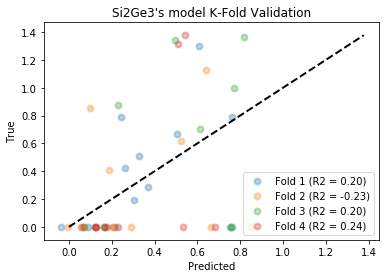

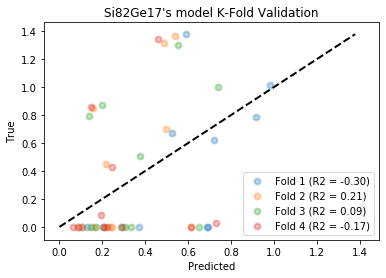

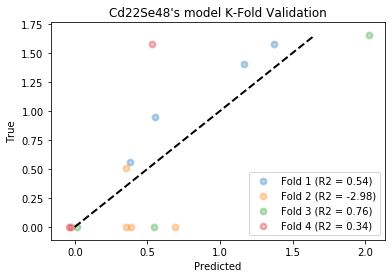

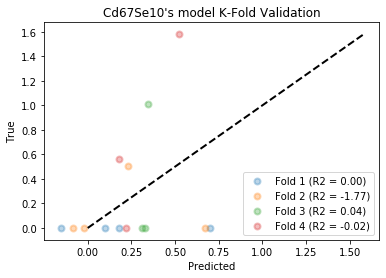

In [8]:
# K fold validation
# https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea
for material, band_gap_prediction_object in band_gap_prediction_objects.items():
    scores = list()
    cv = model_selection.KFold(n_splits=4, shuffle=True)
    fig = plt.figure()
    i = 1

    X_train = band_gap_prediction_object.X_train
    y_train = band_gap_prediction_object.y_train
    model = band_gap_prediction_object.model
    
    for train, test in cv.split(X_train, y_train):
        prediction = model.fit(X_train[train],
                        y_train[train]).predict(X_train[test])
        true = y_train[test]
        score = metrics.r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3, 
                    label='Fold %d (R2 = %0.2f)' % (i,score))
        i = i+1
    plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
                linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{material}'s model K-Fold Validation")
    plt.legend()
    plt.show()

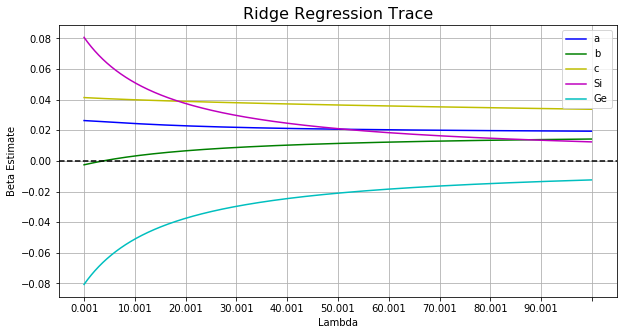

In [9]:
feature_names = band_gap_prediction_objects["Si2Ge3"].band_gap_dataframe_obj.dataframe.keys()[2:]
coef = band_gap_prediction_objects["Si2Ge3"].model_weights 

ridge_df = pd.DataFrame({'variable': feature_names, 'weights': coef})
ridge_train_pred = []
ridge_test_pred = []

X_train = band_gap_prediction_objects["Si2Ge3"].X_train
y_train = band_gap_prediction_objects["Si2Ge3"].y_train
X_test = band_gap_prediction_objects["Si2Ge3"].X_test
y_test = band_gap_prediction_objects["Si2Ge3"].y_test

alphas = np.arange(1e-3,1e2,0.1)

for alpha in alphas:
    ridge_reg = linear_model.Ridge(alpha=alpha)
    ridge_reg.fit(X_train, y_train)
    var_name = str(alpha)
    ridge_df[var_name] = ridge_reg.coef_
    
    # prediction
    ridge_train_pred.append(ridge_reg.predict(X_train))
    ridge_test_pred.append(ridge_reg.predict(X_test))
    
#ridge_df = ridge_df.set_index('variable').T.rename_axis('estimate').rename_axis(None, 1).reset_index()
del ridge_df['weights']
ridge_df = ridge_df.set_index('variable').T

fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(ridge_df.RM, 'r', ridge_df.ZN, 'g', ridge_df.RAD, 'b', ridge_df.CRIM, 'c', ridge_df.TAX, 'y')
ax.plot(
    ridge_df.a, "b",
    ridge_df.b, "g",
    ridge_df.c, "y",
    ridge_df.Si, "m",
    ridge_df.Ge, "c",
)
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel("Lambda")
ax.set_ylabel("Beta Estimate")
ax.set_title("Ridge Regression Trace", fontsize=16)
ax.legend(labels=["a","b","c","Si","Ge"])
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
#ax.set_ylim(-0.001,0.001)
ax.grid(True)

### Random Forest

In [10]:
band_gap_predictions = BandGapPredictions(materials_list,model_type="random_forest")
band_gap_prediction_objects = band_gap_predictions.band_gap_prediction_objects


Starting prediciton for Si2Ge3 using random_forest model type...
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'Si', 'Si_group', 'Si_electronegativity', 'Ge', 'Ge_group', 'Ge_electronegativity', 'molecular_weight']
Making predictions...
predicted bandgap for  Si2Ge3 : 0.5660489999999995

Starting prediciton for Si82Ge17 using random_forest model type...
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'Si', 'Si_group', 'Si_electronegativity', 'Ge', 'Ge_group', 'Ge_electronegativity', 'molecular_weight']
Making predictions...
predicted bandgap for  Si82Ge17 : 0.5933369999999993

Starting prediciton for Cd22Se48 using random_forest model type...
Getting Materials Project data ...
Number of Cd-Se system entries in Materials Project: 5
Number of Cd entries in Materials Project: 4
Number of Se entries in Materials Project: 10
Number of results for training: 19


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'Cd', 'Cd_group', 'Cd_electronegativity', 'Se', 'Se_group', 'Se_electronegativity', 'molecular_weight']
Making predictions...
predicted bandgap for  Cd22Se48 : 0.24687499999999993

Starting prediciton for Cd67Se10 using random_forest model type...
Getting Materials Project data ...
Number of Cd-Se system entries in Materials Project: 5
Number of Cd entries in Materials Project: 4
Number of Se entries in Materials Project: 10
Number of results for training: 19


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'Cd', 'Cd_group', 'Cd_electronegativity', 'Se', 'Se_group', 'Se_electronegativity', 'molecular_weight']
Making predictions...
predicted bandgap for  Cd67Se10 : 0.4087040000000001


In [11]:
for material, band_gap_prediction_object in band_gap_prediction_objects.items():
    x = band_gap_prediction_object.X_train
    y = band_gap_prediction_object.y_train
    band_gap = band_gap_prediction_object.predicted_band_gap
    score = band_gap_prediction_object.model.score(x,y)
    print(f""" 
    {material}
    -----------
    R-squared: {score}
    band gap: {band_gap} eV""")

 
    Si2Ge3
    -----------
    R-squared: 0.8786401033752331
    band gap: 0.5660489999999995 eV
 
    Si82Ge17
    -----------
    R-squared: 0.878059603249379
    band gap: 0.5933369999999993 eV
 
    Cd22Se48
    -----------
    R-squared: 0.954901325297865
    band gap: 0.24687499999999993 eV
 
    Cd67Se10
    -----------
    R-squared: 0.935458120803733
    band gap: 0.4087040000000001 eV


### SVM 

In [12]:
band_gap_predictions = BandGapPredictions(materials_list,model_type="svm")
band_gap_prediction_objects = band_gap_predictions.band_gap_prediction_objects


Starting prediciton for Si2Ge3 using svm model type...
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
Making predictions...


C:\Users\emily\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\emily\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


predicted bandgap for  Si2Ge3 : [0.12469798]

Starting prediciton for Si82Ge17 using svm model type...
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
Making predictions...


C:\Users\emily\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\emily\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


predicted bandgap for  Si82Ge17 : [0.24634538]

Starting prediciton for Cd22Se48 using svm model type...
Getting Materials Project data ...
Number of Cd-Se system entries in Materials Project: 5
Number of Cd entries in Materials Project: 4
Number of Se entries in Materials Project: 10
Number of results for training: 19


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
Making predictions...


C:\Users\emily\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\emily\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


predicted bandgap for  Cd22Se48 : [0.4926537]

Starting prediciton for Cd67Se10 using svm model type...
Getting Materials Project data ...
Number of Cd-Se system entries in Materials Project: 5
Number of Cd entries in Materials Project: 4
Number of Se entries in Materials Project: 10
Number of results for training: 19


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
Making predictions...


C:\Users\emily\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\emily\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


predicted bandgap for  Cd67Se10 : [0.4926537]


### Decision Tree

In [13]:
band_gap_predictions = BandGapPredictions(materials_list,model_type="decision_tree")
band_gap_prediction_objects = band_gap_predictions.band_gap_prediction_objects


Starting prediciton for Si2Ge3 using decision_tree model type...
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'Si', 'Si_group', 'Si_electronegativity', 'Ge', 'Ge_group', 'Ge_electronegativity', 'molecular_weight']
Making predictions...
predicted bandgap for  Si2Ge3 : 0.8585000000000003

Starting prediciton for Si82Ge17 using decision_tree model type...
Getting Materials Project data ...
Number of Ge-Si system entries in Materials Project: 6
Number of Si entries in Materials Project: 39
Number of Ge entries in Materials Project: 17
Number of results for training: 62


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'Si', 'Si_group', 'Si_electronegativity', 'Ge', 'Ge_group', 'Ge_electronegativity', 'molecular_weight']
Making predictions...
predicted bandgap for  Si82Ge17 : 0.8526999999999996

Starting prediciton for Cd22Se48 using decision_tree model type...
Getting Materials Project data ...
Number of Cd-Se system entries in Materials Project: 5
Number of Cd entries in Materials Project: 4
Number of Se entries in Materials Project: 10
Number of results for training: 19


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'Cd', 'Cd_group', 'Cd_electronegativity', 'Se', 'Se_group', 'Se_electronegativity', 'molecular_weight']
Making predictions...
predicted bandgap for  Cd22Se48 : 0.0

Starting prediciton for Cd67Se10 using decision_tree model type...
Getting Materials Project data ...
Number of Cd-Se system entries in Materials Project: 5
Number of Cd entries in Materials Project: 4
Number of Se entries in Materials Project: 10
Number of results for training: 19


C:\Users\emily\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


Training the model...
training params= ['a', 'b', 'c', 'Cd', 'Cd_group', 'Cd_electronegativity', 'Se', 'Se_group', 'Se_electronegativity', 'molecular_weight']
Making predictions...
predicted bandgap for  Cd67Se10 : 0.0
